In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler


In [4]:
# Load dataset

# Define a dictionary mapping data options to file paths
data_options = {
    "1": "/content/EGX_DLY_EGX30, 1D.csv",
    "2": "/content/EGX_DLY_COMI, 1D.csv",
    "3": "/content/EGX_DLY_EMFD, 1D.csv",
    "4": "/content/EGX_DLY_ISPH, 1D.csv"
}

# Print data options
print("1. EGX30\n2. COMI\n3. EMFD\n4. ISPH")

# Loop until valid input is provided
while True:
    # Get user input
    data = input("Enter which data to be read:")

    # Check if user input is valid
    if data in data_options:
        # Read the corresponding CSV file
        data1 = pd.read_csv(data_options[data])
        break
    else:
        print("Invalid input. Please select a valid option.")

# Convert 'time' column from Unix timestamp to datetime
data1['time'] = pd.to_datetime(data1['time'], unit='s')

# Initial data exploration
print(data1.describe())

# Check for missing values
print(data1.isnull().sum())


1. EGX30
2. COMI
3. EMFD
4. ISPH
Enter which data to be read:1
               open          high           low         close
count   3467.000000   3467.000000   3467.000000   3467.000000
mean   10273.047212  10349.720830  10208.701526  10277.758820
std     4505.887737   4551.637938   4470.351546   4511.948268
min     3591.870117   3622.350098   3578.120117   3586.550049
25%     6622.369873   6662.219971   6565.800050   6609.724853
50%     9817.370100   9873.700200   9769.000000   9827.460000
75%    13442.500000  13521.300000  13390.800000  13443.350000
max    30431.301000  30696.000000  29193.900000  30347.301000
time     0
open     0
high     0
low      0
close    0
dtype: int64


There is no Null values to be imputed

In [7]:
# Feature engineering
# Date Features
data1['DayOfWeek'] = data1['time'].dt.dayofweek
data1['WeekOfYear'] = data1['time'].dt.isocalendar().week
data1['Month'] = data1['time'].dt.month
data1['Quarter'] = data1['time'].dt.quarter
data1['Year'] = data1['time'].dt.year
data1.head()

,time,open,high,low,close,DayOfWeek,WeekOfYear,Month,Quarter,Year
0,2009-10-20 08:00:00,7131.700195,7157.509766,7123.200195,7145.149902,1,43,10,4,2009
1,2009-10-21 08:00:00,7139.060059,7139.290039,7062.069824,7062.089844,2,43,10,4,2009
2,2009-10-22 08:00:00,7042.229980,7101.700195,7002.209961,7101.700195,3,43,10,4,2009
3,2009-10-25 08:00:00,7133.209961,7207.540039,7131.310059,7188.750000,6,43,10,4,2009
4,2009-10-26 08:00:00,7177.479980,7261.759766,7174.229980,7249.549805,0,44,10,4,2009


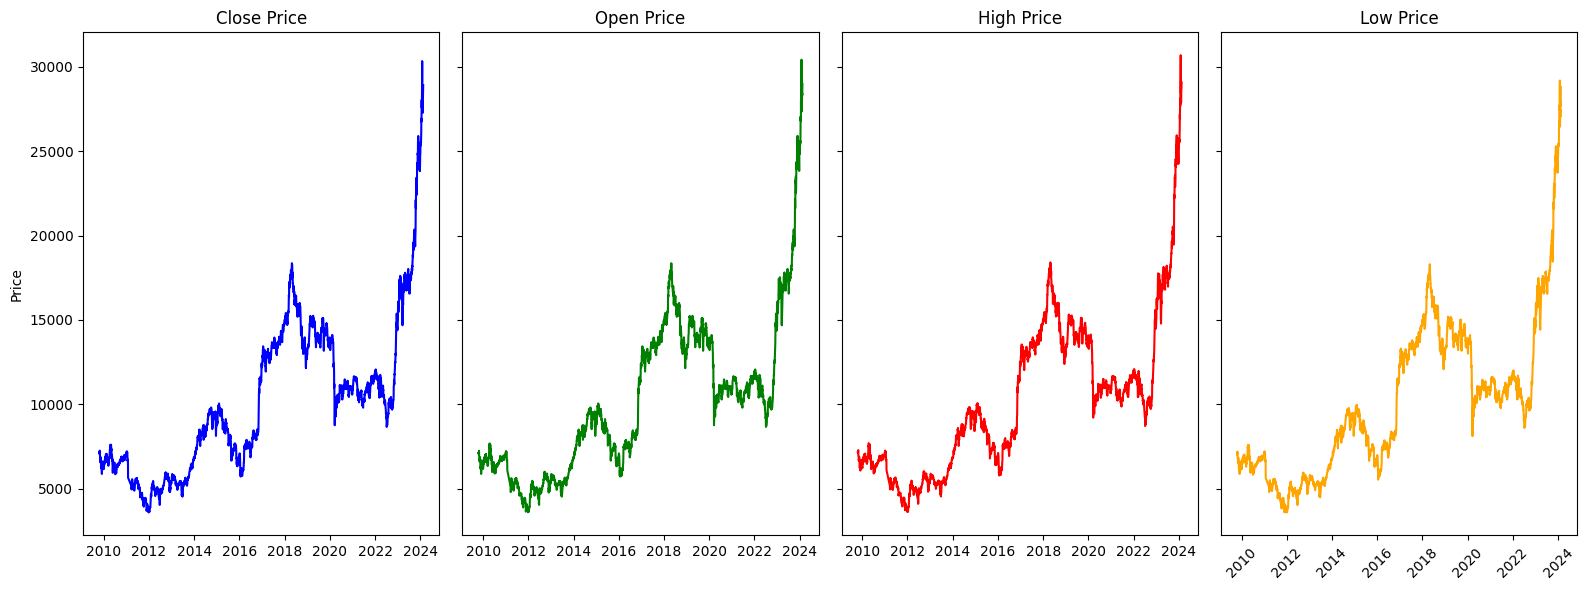

In [6]:
# Create subplots  to show the prices versus time
fig, axs = plt.subplots(1, 4, figsize=(16, 6), sharey=True)

# Plot Close price
axs[0].plot(data1['time'], data1['close'], color='blue')
axs[0].set_title('Close Price')
axs[0].set_ylabel('Price')

# Plot Open price
axs[1].plot(data1['time'], data1['open'], color='green')
axs[1].set_title('Open Price')

# Plot High price
axs[2].plot(data1['time'], data1['high'], color='red')
axs[2].set_title('High Price')

# Plot Low price
axs[3].plot(data1['time'], data1['low'], color='orange')
axs[3].set_title('Low Price')


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


They are almost the same, which is an indication for possible leakage


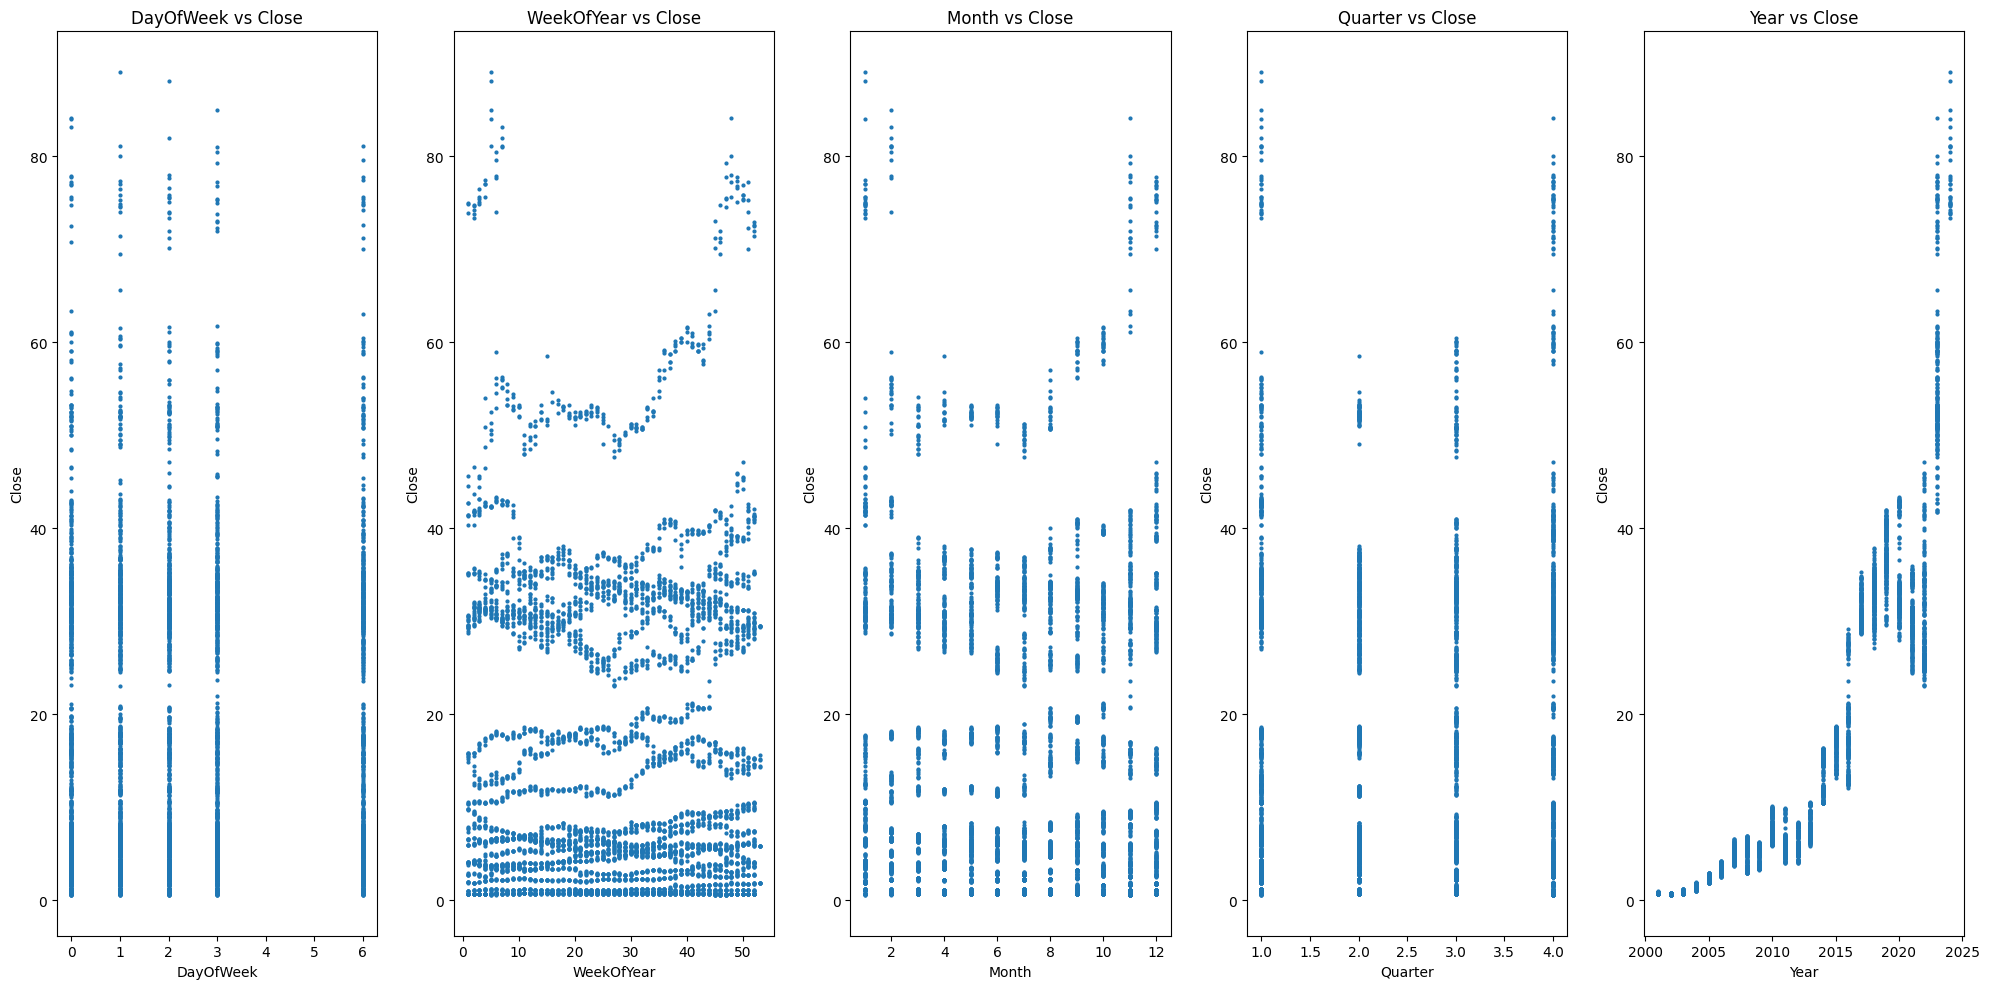

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(20, 10))


axs = axs.flatten()

# Features to plot against the closing price
features = ['DayOfWeek', 'WeekOfYear', 'Month', 'Quarter', 'Year']


for i, feature in enumerate(features):
    axs[i].plot(data1[feature], data1['close'], 'o', markersize=2)
    axs[i].set_title(f'{feature} vs Close')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Close')


plt.tight_layout()
plt.show()


Insights:
- the closing prices are almost the same for the 5 days of the week
- they are higher at the begining and the end of the year (month vs close and quarter vs close graphs)
- there is also an upward tren in the closing prices especially in the last 8-9 years and a huge jump in the last two years

<ipython-input-129-523906391b76>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data1.corr(), annot=True, cmap='coolwarm', fmt=".2f")


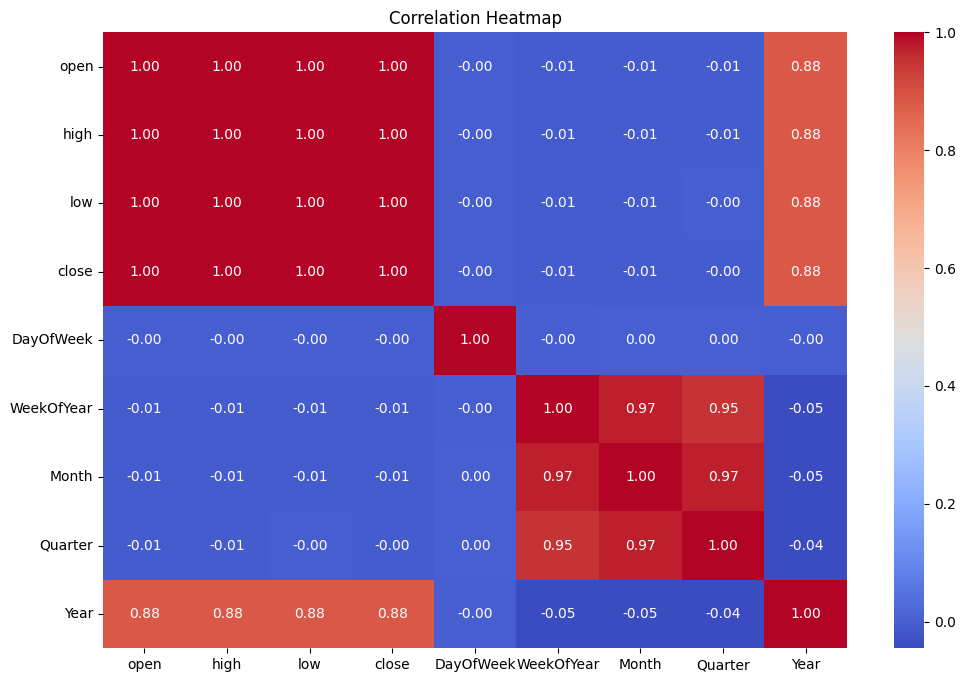

In [ ]:
# Visualize correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data1.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

- there is an exact correlation between open, high, low, close prices which asserts the previous possibility of leakage.
- there is also a high correlation between the year and prices

In [32]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the 'open' column
data1['open_scaled'] = scaler.fit_transform(data1[['open']])


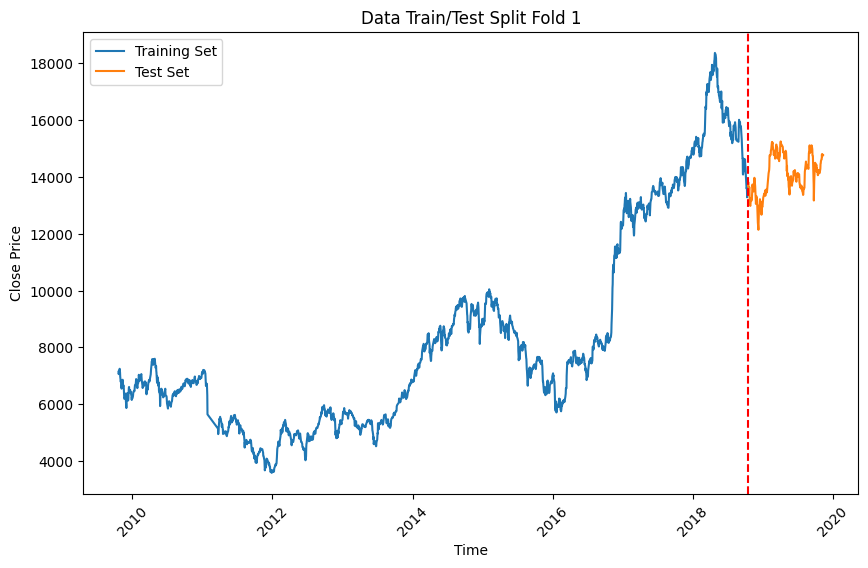

Model: XGBoost


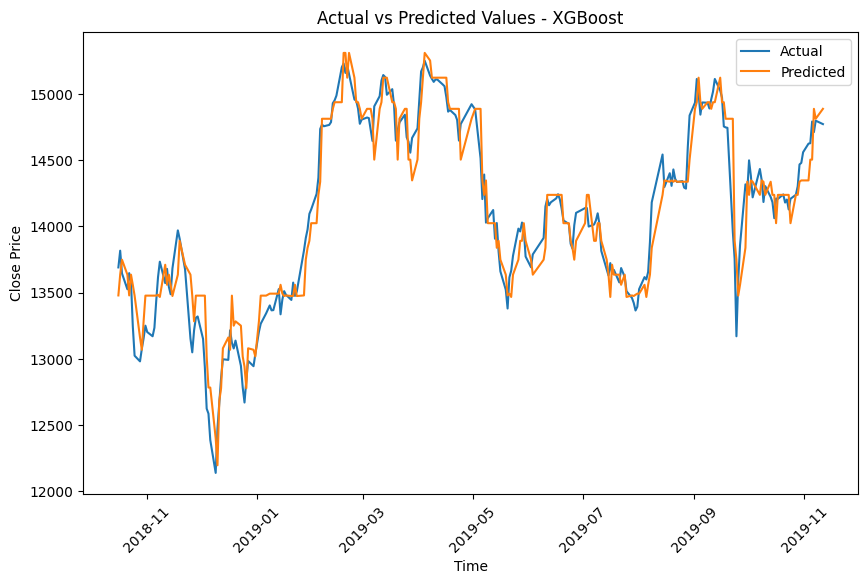

Mean Absolute Error: 135.01321138822112
Mean Squared Error: 32207.233081034865
R^2 Score: 0.9333433199211179
------------------------
Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


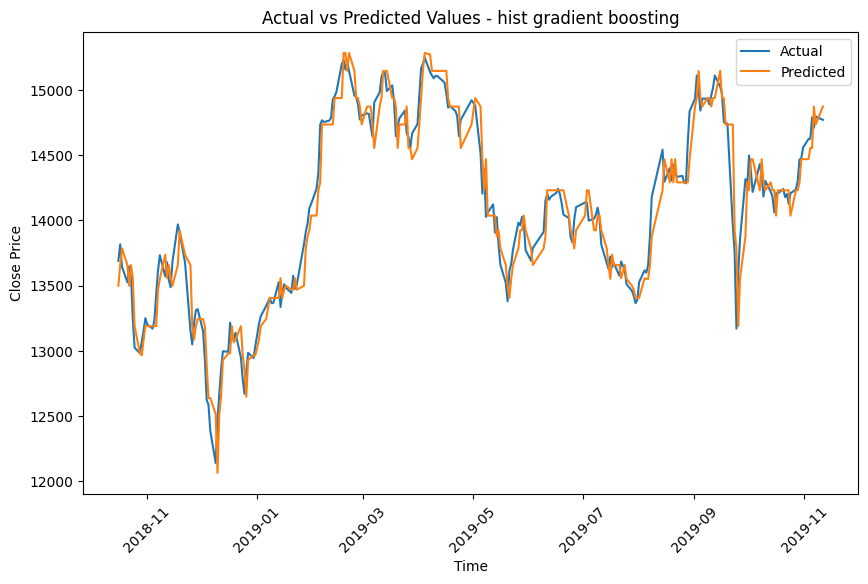

Mean Absolute Error: 124.99570955809926
Mean Squared Error: 27225.182302643945
R^2 Score: 0.9436542635540714
------------------------


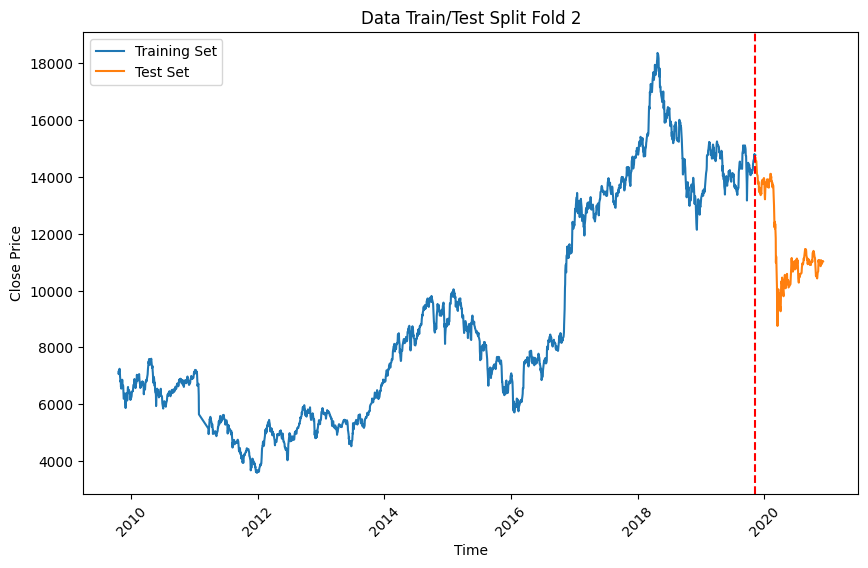

Model: XGBoost


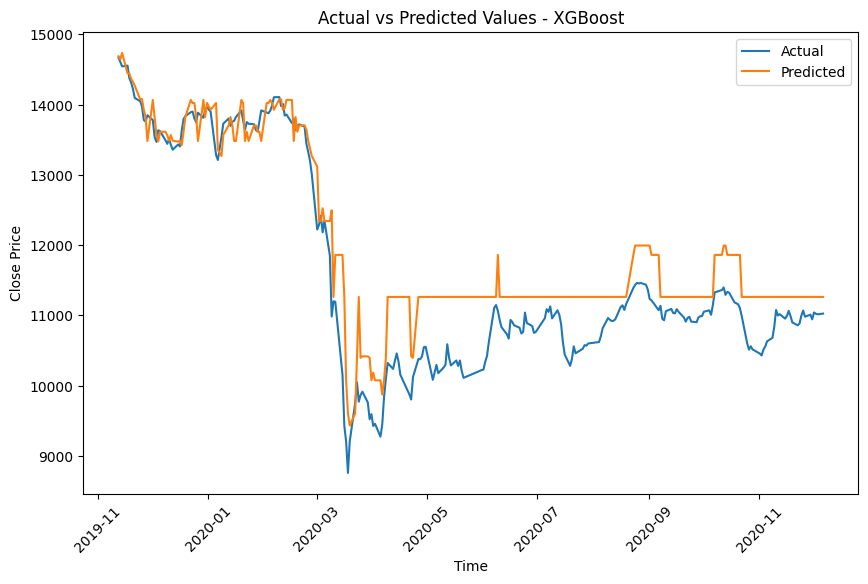

Mean Absolute Error: 435.0273800961539
Mean Squared Error: 304493.3185444673
R^2 Score: 0.8613709275749244
------------------------
Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


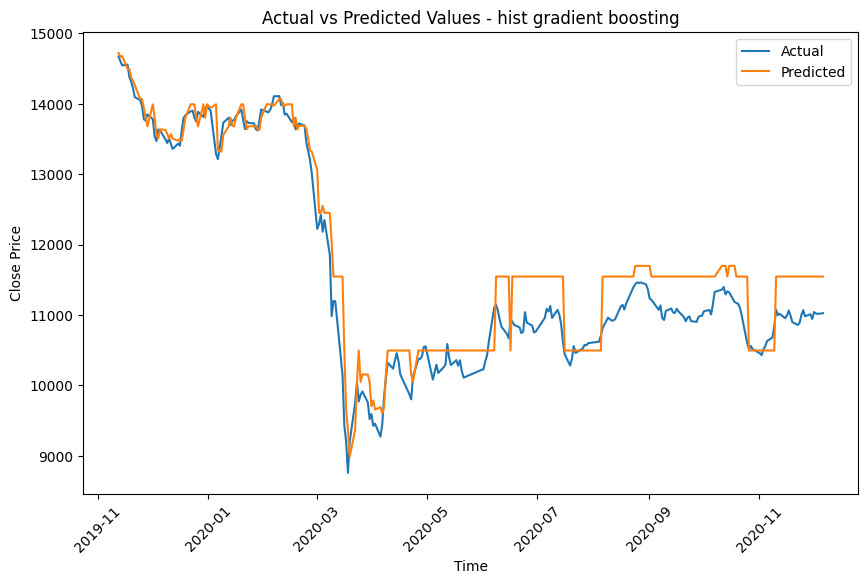

Mean Absolute Error: 318.6175261170899
Mean Squared Error: 163445.7317889017
R^2 Score: 0.9255867737983743
------------------------


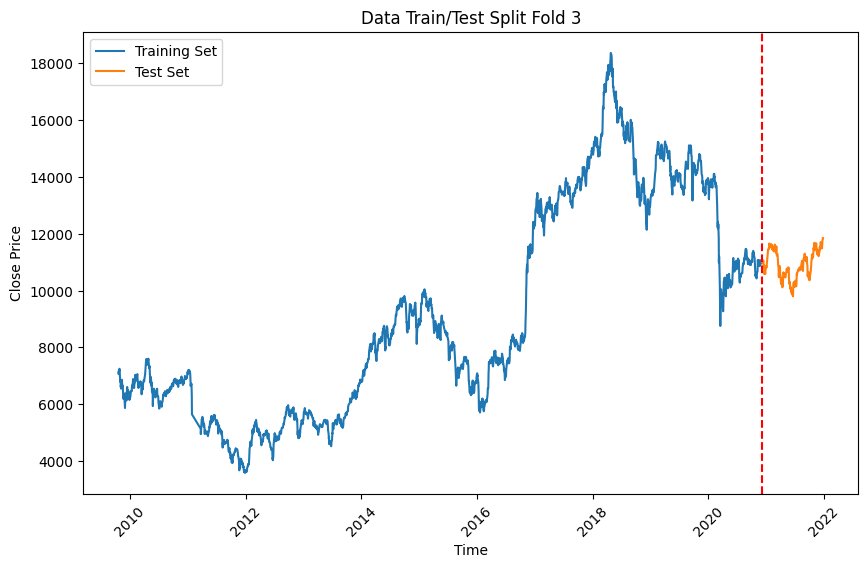

Model: XGBoost


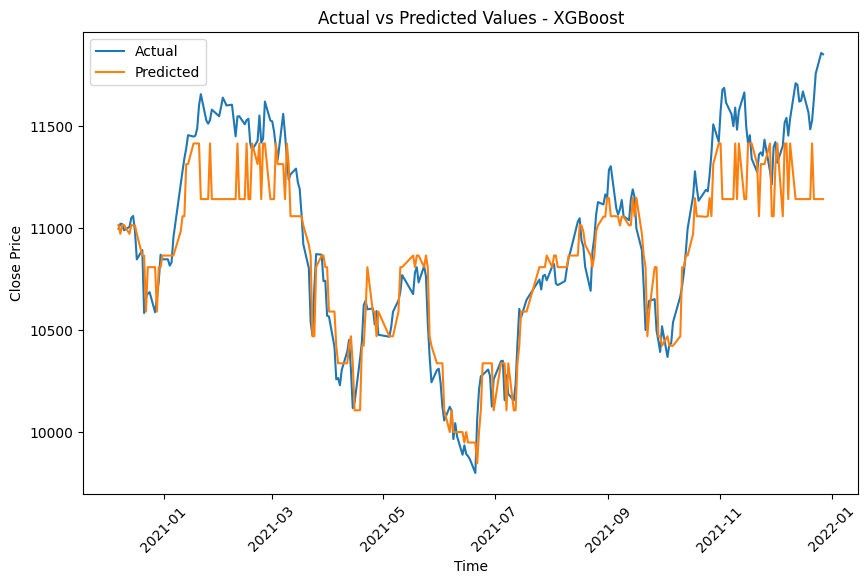

Mean Absolute Error: 155.87474762620198
Mean Squared Error: 46217.08822097298
R^2 Score: 0.8139309171046414
------------------------
Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


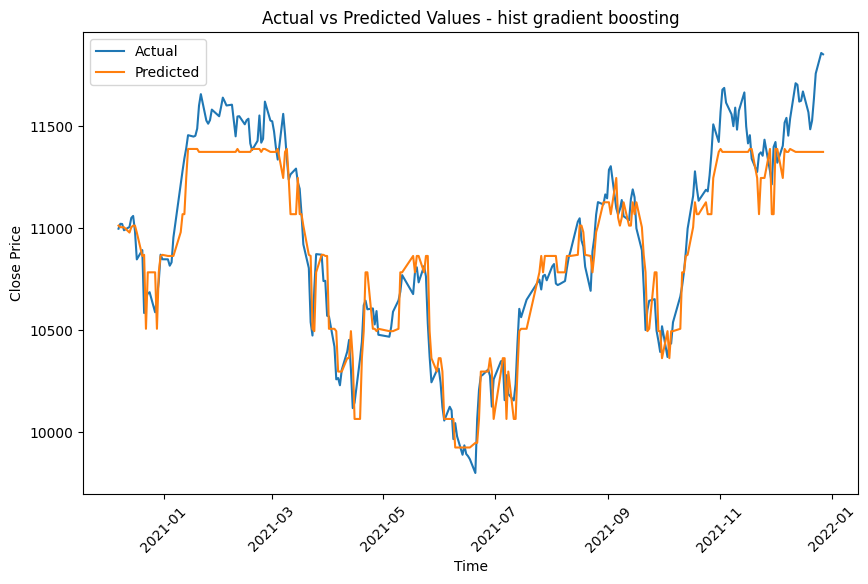

Mean Absolute Error: 120.9647103545668
Mean Squared Error: 22868.732900017487
R^2 Score: 0.9079309337416414
------------------------


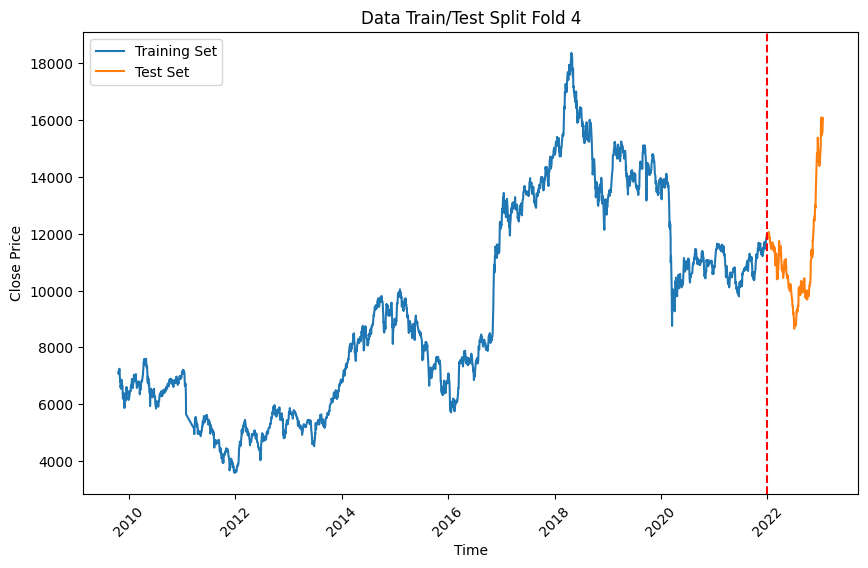

Model: XGBoost


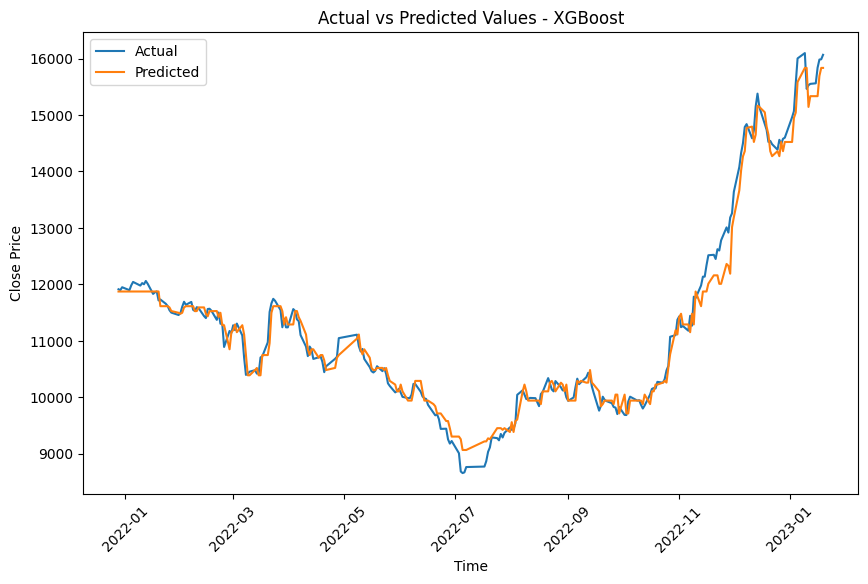

Mean Absolute Error: 161.05832867788462
Mean Squared Error: 49260.62401930203
R^2 Score: 0.9834772177786896
------------------------
Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


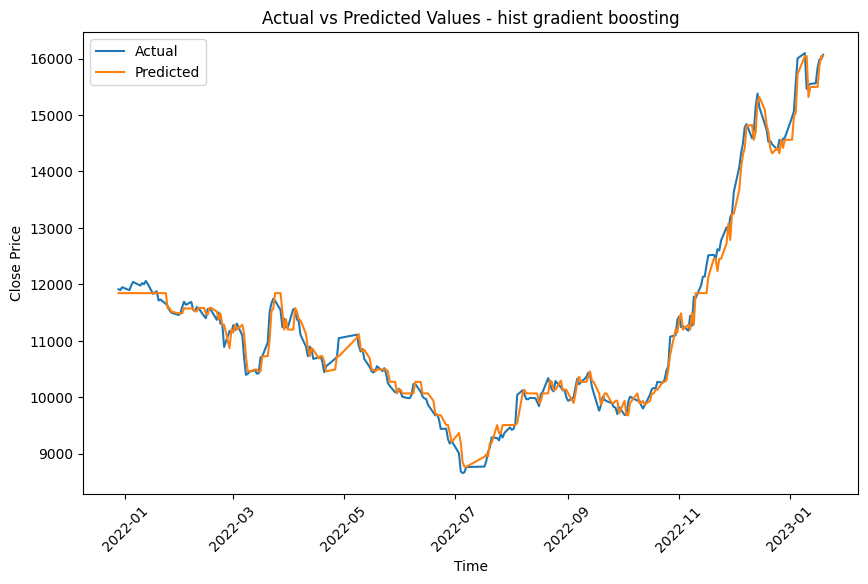

Mean Absolute Error: 137.1726862477134
Mean Squared Error: 32563.419173423918
R^2 Score: 0.9890777209161438
------------------------


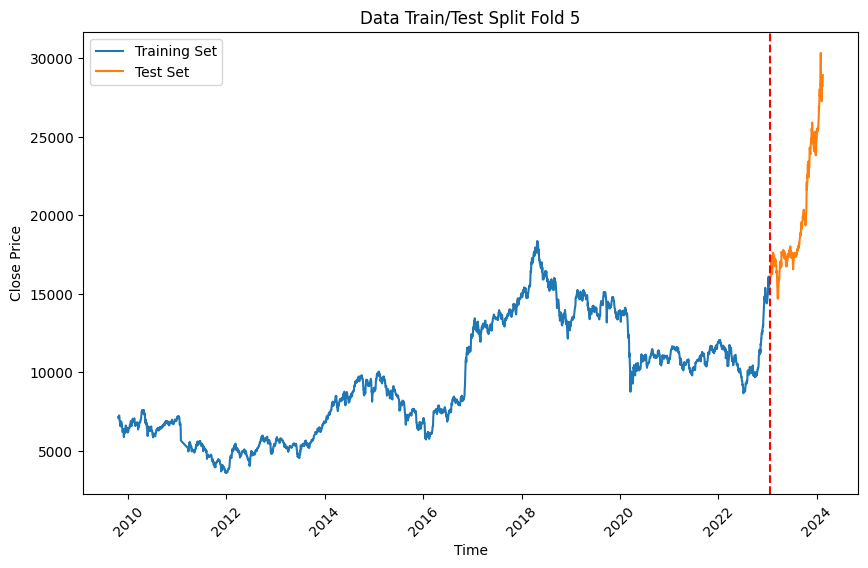

Model: XGBoost


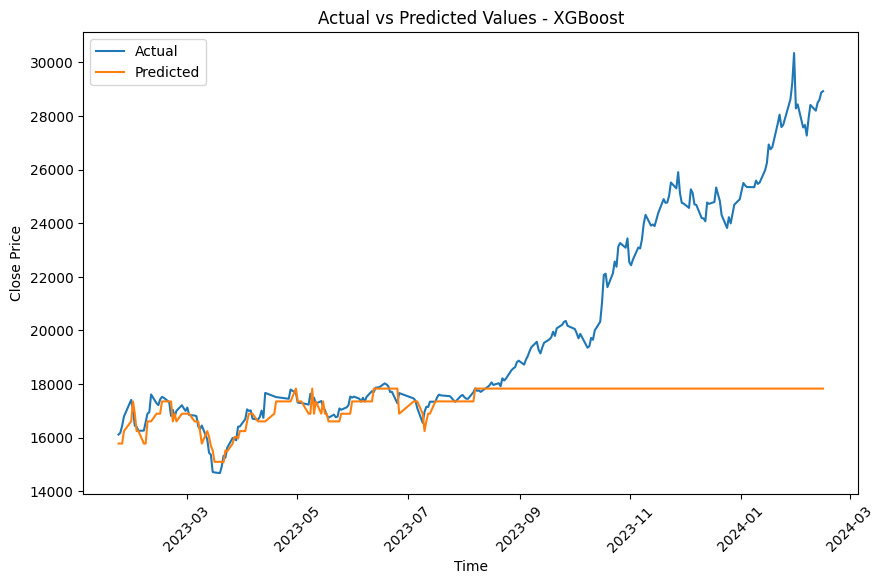

Mean Absolute Error: 2809.4506208533653
Mean Squared Error: 19862864.68497006
R^2 Score: -0.3029207197043009
------------------------
Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


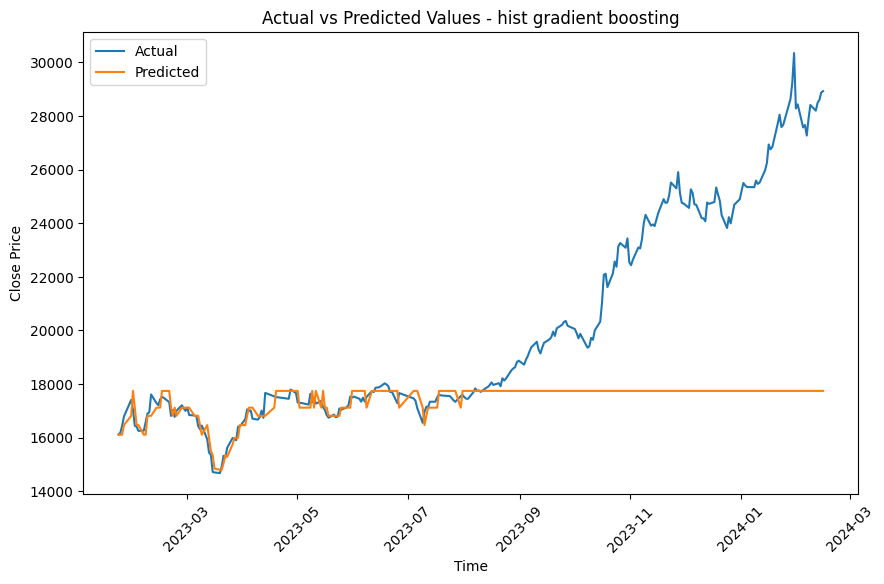

Mean Absolute Error: 2837.9963918603567
Mean Squared Error: 20309560.536136024
R^2 Score: -0.332222096374831
------------------------

Average Evaluation Metrics across Folds:
XGBoost
Average MAE: 739.2848577283654
Average MSE: 4059008.589767167
Average R2: 0.6578403325350144
------------------------
hist gradient boosting
Average MAE: 707.9494048275652
Average MSE: 4111132.7204602016
Average R2: 0.6868055191270799
------------------------

Best Model: hist gradient boosting


In [33]:
# Splitting the dataset into features (X) and target variable (y)
#keep only the open and year features as they have the highest correlation and they will be available when prediciting the future


# Extract features and target
X = data1[['open_scaled', 'Year', 'time']]
y = data1[['close']]


models = {
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "hist gradient boosting": HistGradientBoostingRegressor(random_state=0),
}


# Results dictionary to store evaluation metrics
results = {}
# Cross-validation with TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5,test_size=int(365*5/7))  # TimeSeriesSplit for cross-validation on time series data

fold = 1
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(X_train['time'], y_train, label='Training Set')
    ax.plot(X_test['time'], y_test, label='Test Set')
    ax.axvline(x=X_train['time'].iloc[-1], color='red', ls='--')  # Vertical line at the end of training set
    ax.legend(['Training Set', 'Test Set'])
    ax.set_title(f'Data Train/Test Split Fold {fold}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Close Price')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()

    X_test_time = X_test['time']
    X_train = X_train.drop(columns=['time'])
    X_test = X_test.drop(columns=['time'])

    fold +=1


    for name, model in models.items():
        print("Model:", name)

        # Train the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the testing set
        y_pred = model.predict(X_test)

        # Plot actual vs predicted values against time
        plt.figure(figsize=(10, 6))
        plt.plot(X_test_time, y_test, label='Actual')
        plt.plot(X_test_time, y_pred, label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Close Price')
        plt.title(f'Actual vs Predicted Values - {name}')
        plt.legend()
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.show()


        # Calculate evaluation metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print("Mean Absolute Error:", mae)
        print("Mean Squared Error:", mse)
        print("R^2 Score:", r2)
        print("------------------------")

        # Store evaluation metrics in results dictionary
        if name not in results:
            results[name] = {'MAE': [], 'MSE': [], 'R2': []}
        results[name]['MAE'].append(mae)
        results[name]['MSE'].append(mse)
        results[name]['R2'].append(r2)

# Calculate average evaluation metrics across folds
average_results = {}
for name, metrics in results.items():
    average_results[name] = {
        'Average MAE': np.mean(metrics['MAE']),
        'Average MSE': np.mean(metrics['MSE']),
        'Average R2': np.mean(metrics['R2'])
    }

# Print average evaluation metrics
print("\nAverage Evaluation Metrics across Folds:")
for name, metrics in average_results.items():
    print(name)
    print("Average MAE:", metrics['Average MAE'])
    print("Average MSE:", metrics['Average MSE'])
    print("Average R2:", metrics['Average R2'])
    print("------------------------")

# Determine the best model based on the average evaluation metrics
best_model = min(average_results, key=lambda x: average_results[x]['Average MAE'])
print("\nBest Model:", best_model)



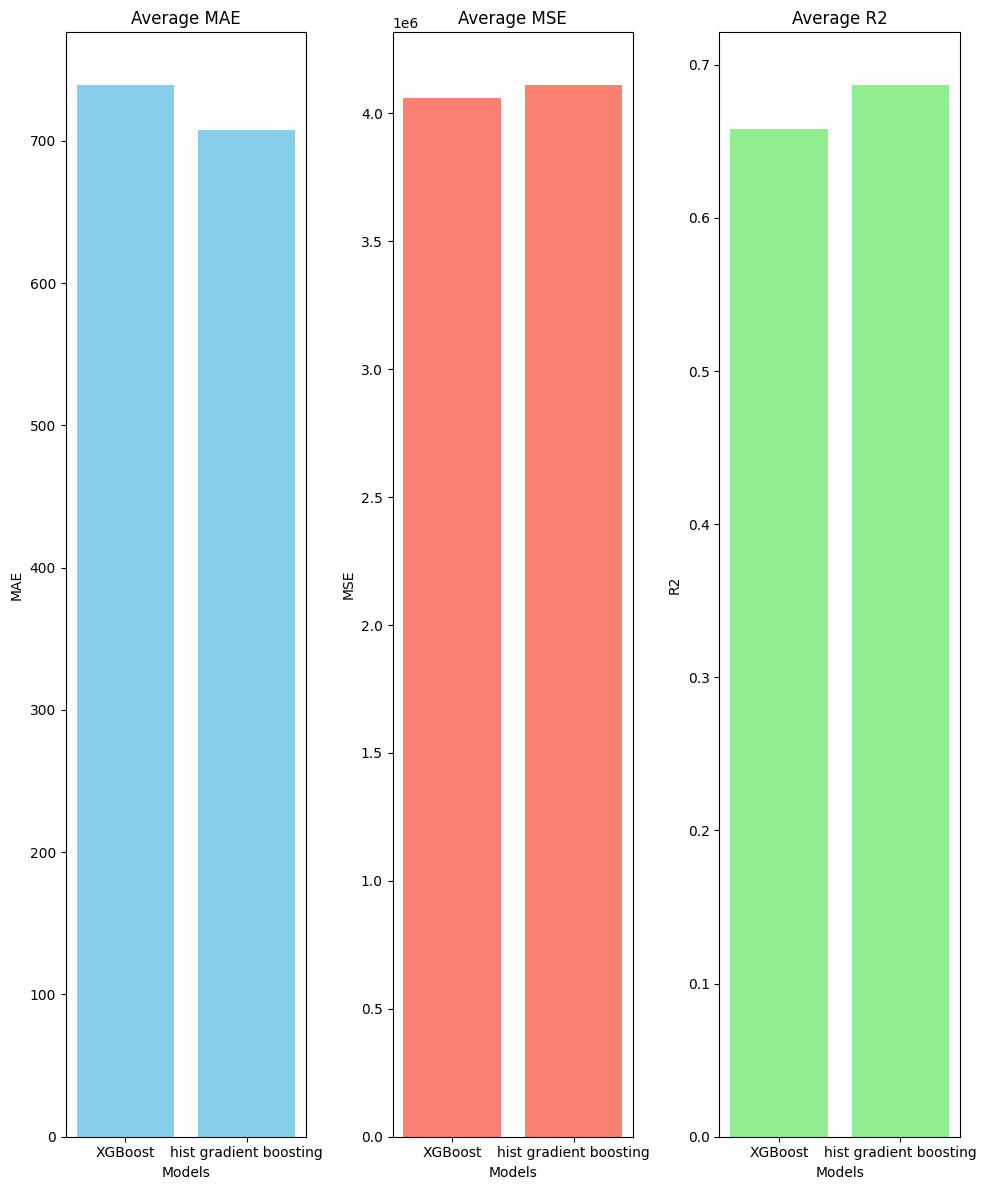


Best Model: hist gradient boosting


In [55]:
# Extract metrics for plotting
models = list(average_results.keys())
avg_mae = [metrics['Average MAE'] for metrics in average_results.values()]
avg_mse = [metrics['Average MSE'] for metrics in average_results.values()]
avg_r2 = [metrics['Average R2'] for metrics in average_results.values()]

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 12))

# Average MAE
ax1.bar(models, avg_mae, color='skyblue')
ax1.set_title('Average MAE')
ax1.set_xlabel('Models')
ax1.set_ylabel('MAE')

# Average MSE
ax2.bar(models, avg_mse, color='salmon')
ax2.set_title('Average MSE')
ax2.set_xlabel('Models')
ax2.set_ylabel('MSE')

# Average R2
ax3.bar(models, avg_r2, color='lightgreen')
ax3.set_title('Average R2')
ax3.set_xlabel('Models')
ax3.set_ylabel('R2')

# Rotate x-axis labels for better readability
for ax in (ax1, ax2, ax3):
    ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Print the best model
print("\nBest Model:", best_model)

hist gradient boosting is doing a letter bit better than XGboost.

Note: the choice of these two models as they accept null values in the features.

will try to predict the future with NaNs in the open price column as we won't have that data except in that date at 8 am

In [18]:
#time for the next month
future = pd.date_range('2024-02-15 08:00:00', '2024-03-15 08:00:00', freq='1d')
# Filter out Fridays and Saturdays
future = future[(future.weekday != 4) & (future.weekday != 5)]  # 4 corresponds to Friday, 5 corresponds to Saturday (Monday=0, Sunday=6)
future_df = pd.DataFrame(index= future)

data = data1.copy()

data.set_index('time', inplace=True)
df_and_future = pd.concat([data[['open_scaled']], future_df])

df_and_future.index = pd.to_datetime(df_and_future.index)

df_and_future['Year'] = df_and_future.index.year

# Reset the index to turn the DateTimeIndex into a column
df_and_future.reset_index(inplace=True)

# Rename the column to 'time'
df_and_future.rename(columns={'index': 'time'}, inplace=True)
data.reset_index(inplace=True)
data.rename(columns={'index': 'time'}, inplace=True)

df_and_future.tail(15)

,time,open,Year
3473,2024-02-25 08:00:00,NaN,2024
3474,2024-02-26 08:00:00,NaN,2024
3475,2024-02-27 08:00:00,NaN,2024
3476,2024-02-28 08:00:00,NaN,2024
3477,2024-02-29 08:00:00,NaN,2024
3478,2024-03-03 08:00:00,NaN,2024
3479,2024-03-04 08:00:00,NaN,2024
3480,2024-03-05 08:00:00,NaN,2024
3481,2024-03-06 08:00:00,NaN,2024
3482,2024-03-07 08:00:00,NaN,2024


Model: XGBoost


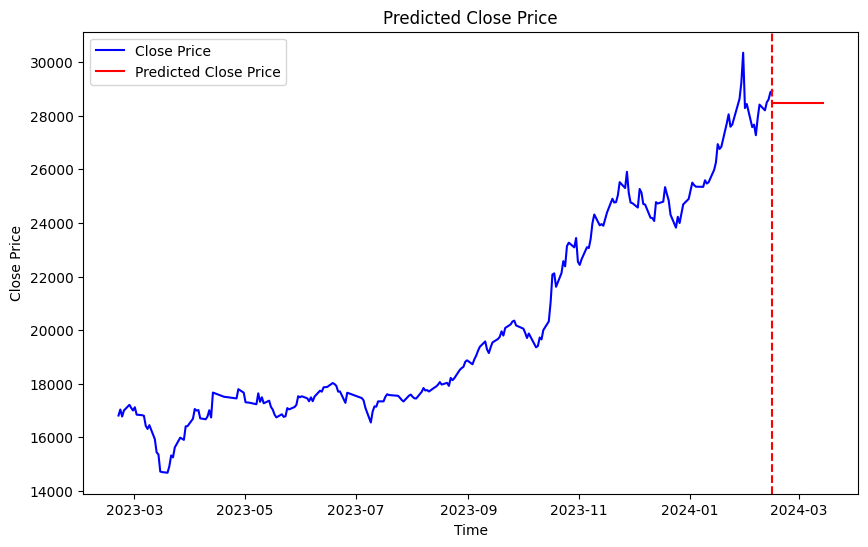

Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


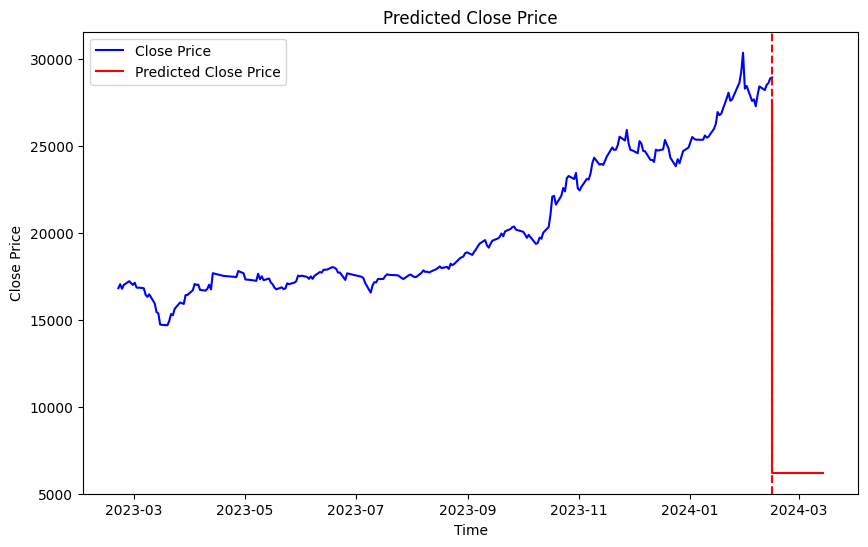

In [29]:
X_all = data1[['open_scaled','Year',]]

y_all = data1[['close']]

X_test = df_and_future[data1.index[-1]:][['open_scaled', 'Year']]
# Initialize models
models = {
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "hist gradient boosting": HistGradientBoostingRegressor(random_state=0),
}



# Results dictionary to store evaluation metrics
results = {}


for name, model in models.items():
    print("Model:", name)

    # Train the model on the training data
    model.fit(X_all, y_all)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame(data=y_pred, index=X_test.index, columns=['predicted_close'])

    # Concatenate the predictions DataFrame with df_and_future
    df_and_future_predicted = pd.concat([df_and_future, predictions_df], axis=1)


    df_and_future_predicted['close'] = data1['close']
    # # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_and_future_predicted['time'].tail(261), df_and_future_predicted['close'].tail(261), label='Close Price', color='blue')
    plt.plot(df_and_future_predicted['time'].tail(261), df_and_future_predicted['predicted_close'].tail(261), label='Predicted Close Price', color='red')
    plt.axvline(x=data1.iloc[-1]['time'], color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price')
    plt.legend()
    plt.show()

will try the same but with imputing the open values with knn imputer

In [35]:
#time for the next month
future = pd.date_range('2024-02-15 08:00:00', '2024-03-15 08:00:00', freq='1d')
# Filter out Fridays and Saturdays
future = future[(future.weekday != 4) & (future.weekday != 5)]  # 4 corresponds to Friday, 5 corresponds to Saturday (Monday=0, Sunday=6)
future_df = pd.DataFrame(index= future)

data = data1.copy()

data.set_index('time', inplace=True)
df_and_future = pd.concat([data[['open_scaled']], future_df])

df_and_future.index = pd.to_datetime(df_and_future.index)

df_and_future['Year'] = df_and_future.index.year

# Reset the index to turn the DateTimeIndex into a column
df_and_future.reset_index(inplace=True)

# Rename the column to 'time'
df_and_future.rename(columns={'index': 'time'}, inplace=True)
data.reset_index(inplace=True)
data.rename(columns={'index': 'time'}, inplace=True)

imputer = KNNImputer(n_neighbors=260)
df_and_future[['open_scaled']] = imputer.fit_transform(df_and_future[['open_scaled']])


df_and_future.tail(15)

,time,open_scaled,Year
3473,2024-02-25 08:00:00,0.248931,2024
3474,2024-02-26 08:00:00,0.248931,2024
3475,2024-02-27 08:00:00,0.248931,2024
3476,2024-02-28 08:00:00,0.248931,2024
3477,2024-02-29 08:00:00,0.248931,2024
3478,2024-03-03 08:00:00,0.248931,2024
3479,2024-03-04 08:00:00,0.248931,2024
3480,2024-03-05 08:00:00,0.248931,2024
3481,2024-03-06 08:00:00,0.248931,2024
3482,2024-03-07 08:00:00,0.248931,2024


knn imputer doesn't do a good job; it gives all rows the same value

Model: XGBoost


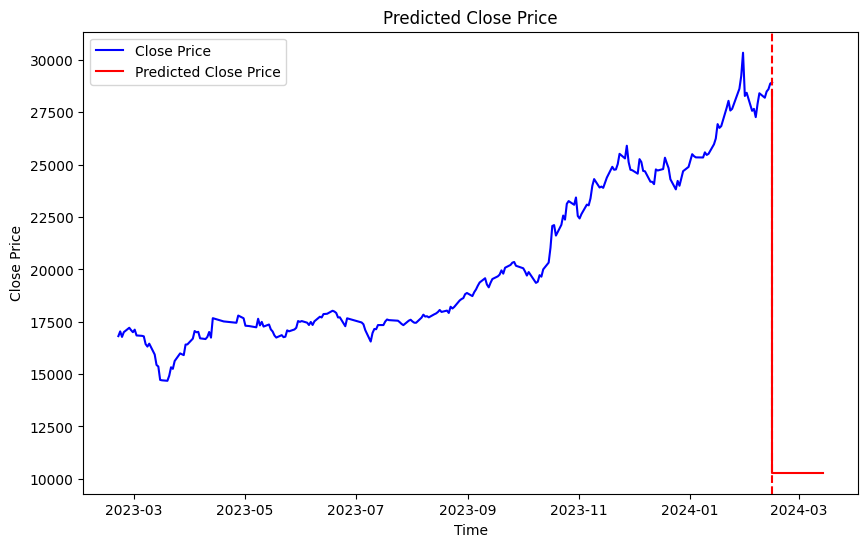

Model: hist gradient boosting


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


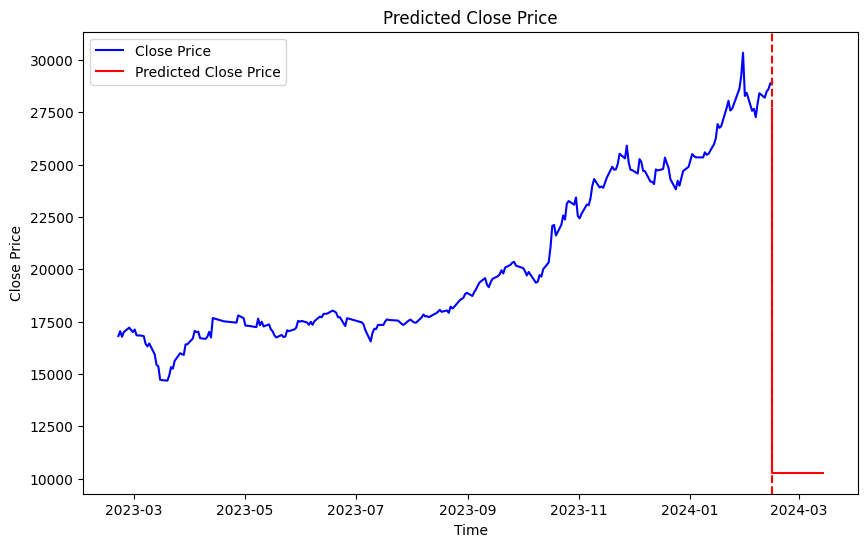

In [36]:
X_all = data1[['open_scaled','Year',]]

y_all = data1[['close']]

X_test = df_and_future[data1.index[-1]:][['open_scaled', 'Year']]
# Initialize models
models = {
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "hist gradient boosting": HistGradientBoostingRegressor(random_state=0),
}



# Results dictionary to store evaluation metrics
results = {}


for name, model in models.items():
    print("Model:", name)

    # Train the model on the training data
    model.fit(X_all, y_all)

    # Make predictions on the testing set
    y_pred = model.predict(X_test)

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame(data=y_pred, index=X_test.index, columns=['predicted_close'])

    # Concatenate the predictions DataFrame with df_and_future
    df_and_future_predicted = pd.concat([df_and_future, predictions_df], axis=1)


    df_and_future_predicted['close'] = data1['close']
    # # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_and_future_predicted['time'].tail(261), df_and_future_predicted['close'].tail(261), label='Close Price', color='blue')
    plt.plot(df_and_future_predicted['time'].tail(261), df_and_future_predicted['predicted_close'].tail(261), label='Predicted Close Price', color='red')
    plt.axvline(x=data1.iloc[-1]['time'], color='red', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.title('Predicted Close Price')
    plt.legend()
    plt.show()

Made the predicition even worse than having Null values in the open column

# Deep learning approach using lstm

In [37]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib. pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [69]:
# Load dataset

# Define a dictionary mapping data options to file paths
data_options = {
    "1": "/content/EGX_DLY_EGX30, 1D.csv",
    "2": "/content/EGX_DLY_COMI, 1D.csv",
    "3": "/content/EGX_DLY_EMFD, 1D.csv",
    "4": "/content/EGX_DLY_ISPH, 1D.csv"
}

# Print data options
print("1. EGX30\n2. COMI\n3. EMFD\n4. ISPH")

# Loop until valid input is provided
while True:
    # Get user input
    data = input("Enter which data to be read:")

    # Check if user input is valid
    if data in data_options:
        # Read the corresponding CSV file
        df = pd.read_csv(data_options[data])
        break
    else:
        print("Invalid input. Please select a valid option.")

# Convert 'time' column from Unix timestamp to datetime
df['time'] = pd.to_datetime(data1['time'], unit='s')



1. EGX30
2. COMI
3. EMFD
4. ISPH
Enter which data to be read:1


In [70]:
print("Dataframe Shape: ", df. shape)
print("Null Value Present: ", df.isnull().values.any())

Dataframe Shape:  (3467, 5)
Null Value Present:  False


<Axes: >

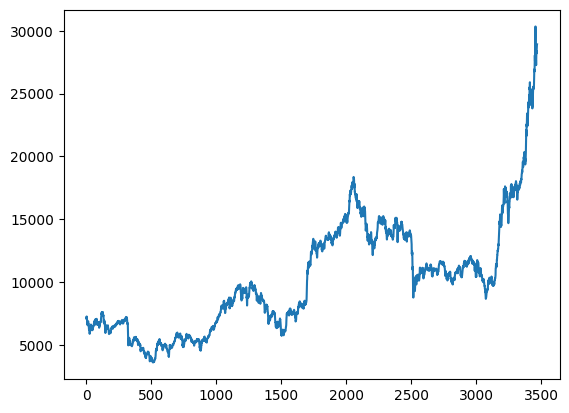

In [71]:
df["close"].plot()

In [72]:
df.columns

Index(['time', 'open', 'high', 'low', 'close'], dtype='object')

In [73]:
output_var = pd.DataFrame(df['close'])
#Selecting the Features

features_scaling = ['open']

In [74]:
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features_scaling])
feature_transform= pd.DataFrame(columns=features_scaling, data=feature_transform, index=df.index)

feature_transform.head()

,open
0,0.131889
1,0.132163
2,0.128556
3,0.131945
4,0.133595


In [75]:
tscv = TimeSeriesSplit()  # TimeSeriesSplit for cross-validation on time series data
for train_index, test_index in tscv.split(feature_transform):
    train_idx, test_idx = feature_transform.index[train_index], feature_transform.index[test_index]
    X_train, X_test = feature_transform.iloc[:len(train_index)], feature_transform.iloc[len(train_index): (len(train_index) + len(test_index))]
    y_train, y_test = output_var.iloc[:len(train_index)].values.ravel(), output_var.iloc[len(train_index): (len(train_index) + len(test_index))].values.ravel()



In [76]:
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

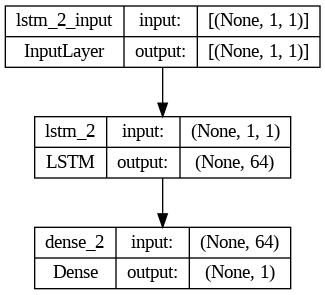

In [77]:
lstm = Sequential()
lstm.add(LSTM(64, input_shape=(1, trainX.shape[1]), activation="relu", return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss="mean_absolute_error", optimizer="adam")
plot_model(lstm, show_shapes=True, show_layer_names=True)

In [78]:
history=lstm.fit(X_train, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False)

Epoch 1/200
362/362 [==============================] - 3s 4ms/step - loss: 9282.9512
Epoch 2/200
362/362 [==============================] - 1s 4ms/step - loss: 9270.3926
Epoch 3/200
362/362 [==============================] - 1s 4ms/step - loss: 9239.0986
Epoch 4/200
362/362 [==============================] - 1s 4ms/step - loss: 9190.9707
Epoch 5/200
362/362 [==============================] - 1s 4ms/step - loss: 9130.3223
Epoch 6/200
362/362 [==============================] - 2s 5ms/step - loss: 9059.9365
Epoch 7/200
362/362 [==============================] - 2s 5ms/step - loss: 8981.2705
Epoch 8/200
362/362 [==============================] - 2s 4ms/step - loss: 8895.1436
Epoch 9/200
362/362 [==============================] - 1s 4ms/step - loss: 8802.0225
Epoch 10/200
362/362 [==============================] - 1s 4ms/step - loss: 8702.1982
Epoch 11/200
362/362 [==============================] - 2s 4ms/step - loss: 8595.8711
Epoch 12/200
362/362 [==============================] - 1s 4ms/

In [79]:
y_pred= lstm.predict(X_test)

19/19 [==============================] - 0s 2ms/step


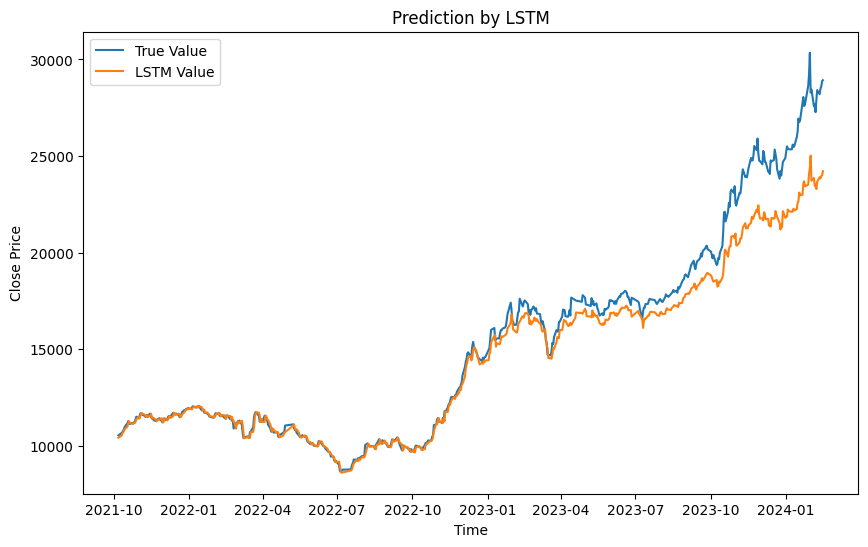

In [80]:
#Predicted vs True Adj Close Value – LSTM
plt.figure(figsize=(10, 6))
plt.plot(df['time'].tail(577),y_test, label="True Value")
plt.plot(df['time'].tail(577),y_pred, label="LSTM Value")
plt.title("Prediction by LSTM")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.show()


In [81]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

Mean Absolute Error (MAE): 766.5889581807843
Mean Squared Error (MSE): 1881273.617615958
R^2 Score: 0.9315658561399032


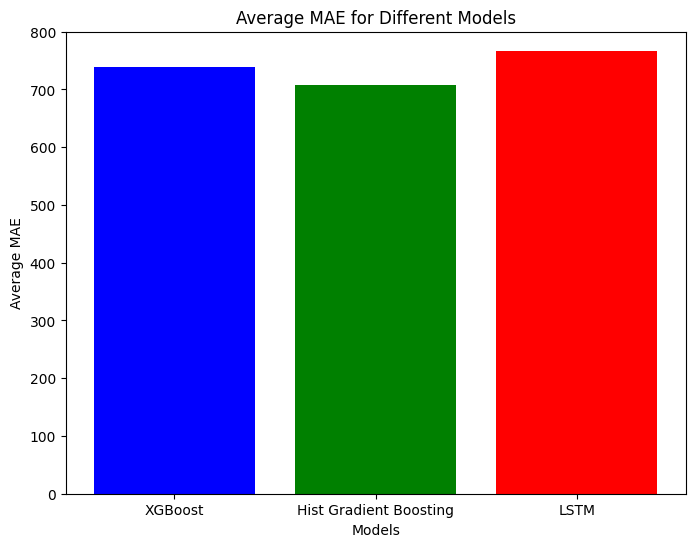

In [84]:
models = ['XGBoost', 'Hist Gradient Boosting', 'LSTM']
mae_values = [avg_mae[0], avg_mae[1], mae]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(models, mae_values, color=['blue', 'green', 'red'])
plt.title('Average MAE for Different Models')
plt.xlabel('Models')
plt.ylabel('Average MAE')
plt.ylim(0, 800)  # Adjust the limits if needed
plt.show()
